Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (188318, 132)

First few rows:
   id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont6     cont7  \
0   1    A    B    A    B    A    A    A    A    B  ...  0.718367  0.335060   
1   2    A    B    A    A    A    A    A    A    B  ...  0.438917  0.436585   
2   5    A    B    A    A    B    A    A    A    B  ...  0.289648  0.315545   
3  10    B    B    A    B    A    A    A    A    B  ...  0.440945  0.391128   
4  11    A    B    A    B    A    A    A    A    B  ...  0.178193  0.247408   

     cont8    cont9   cont10    cont11    cont12    cont13    cont14     loss  
0  0.30260  0.67135  0.83510  0.569745  0.594646  0.822493  0.714843  2213.18  
1  0.60087  0.35127  0.43919  0.338312  0.366307  0.611431  0.304496  1283.60  
2  0.27320  0.26076  0.32446  0.381398  0.373424  0.195709  0.774425  3005.09  
3  0.31796  0.32128  0.44467  

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   58.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   59.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   27.4s
[Parall

Cross-validation MAE: 0.4355 (+/- 0.0008)
Training final model...


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Training completed in 272.60 seconds (4.54 minutes)


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.7s finished



=== Model Evaluation ===

Model: Optimized Random Forest
R² (log scale): 0.5263
MAE (log scale): 0.4339
RMSE (log scale): 0.5588
MAE (original): 1208.7945
Median AE (original): 693.5112
RMSE (original): 2087.7202

=== Feature Importance Analysis ===

Top 15 Most Important Features:
    feature  importance
93    cat80    0.200708
92    cat79    0.113121
114  cat101    0.079562
25    cat12    0.041235
94    cat81    0.039940
1     cont2    0.027923
116  cat103    0.027462
14     cat1    0.026675
13   cont14    0.026564
6     cont7    0.026172
100   cat87    0.024194
113  cat100    0.019454
124  cat111    0.019105
127  cat114    0.016444
66    cat53    0.015150


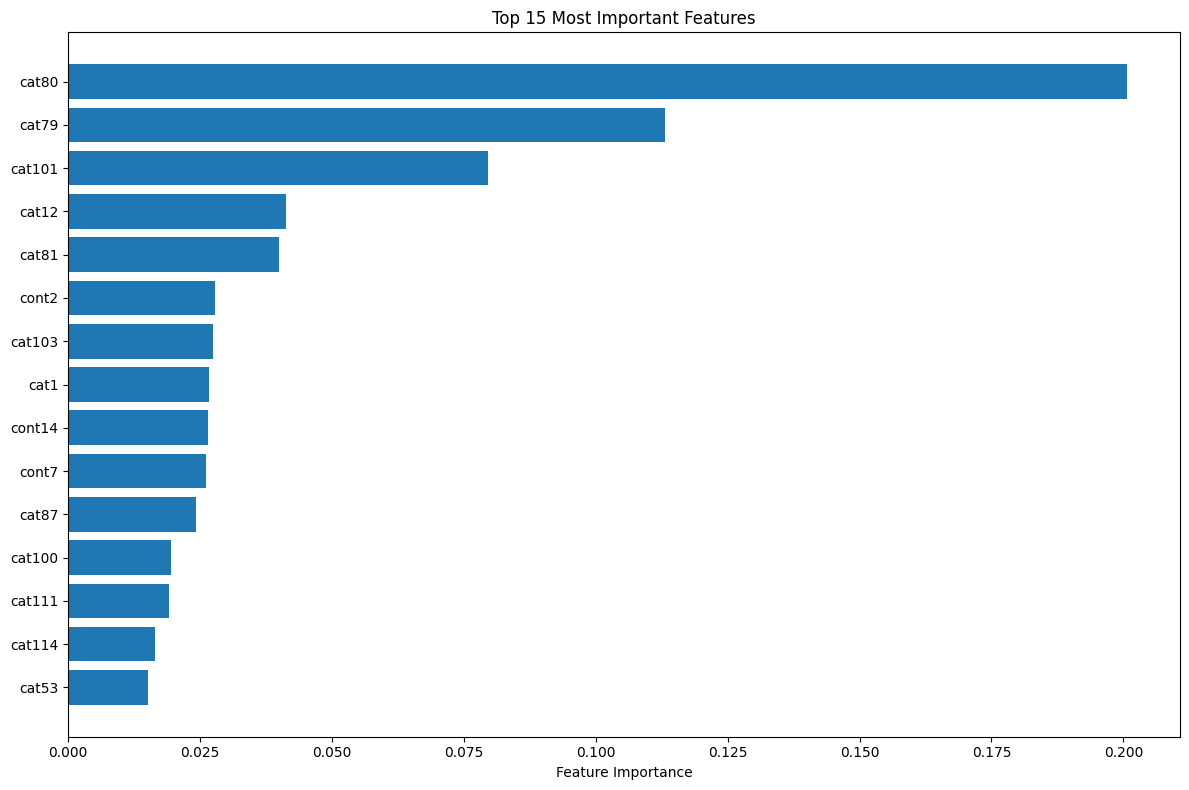


Number of features explaining 95% of importance: 51

=== Error Analysis ===


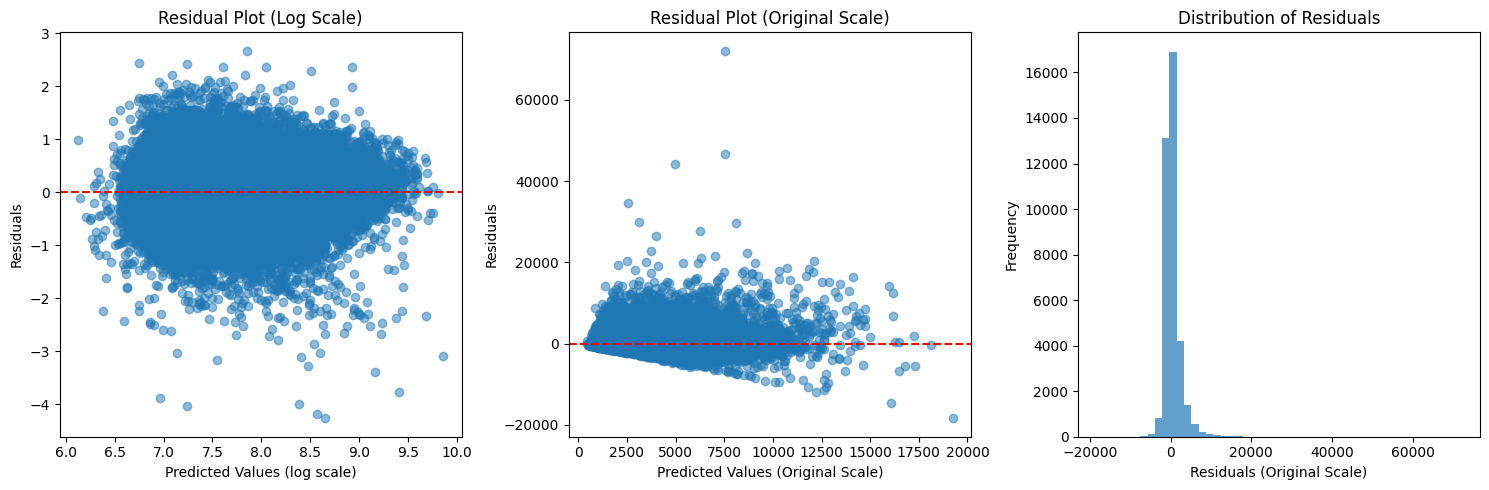

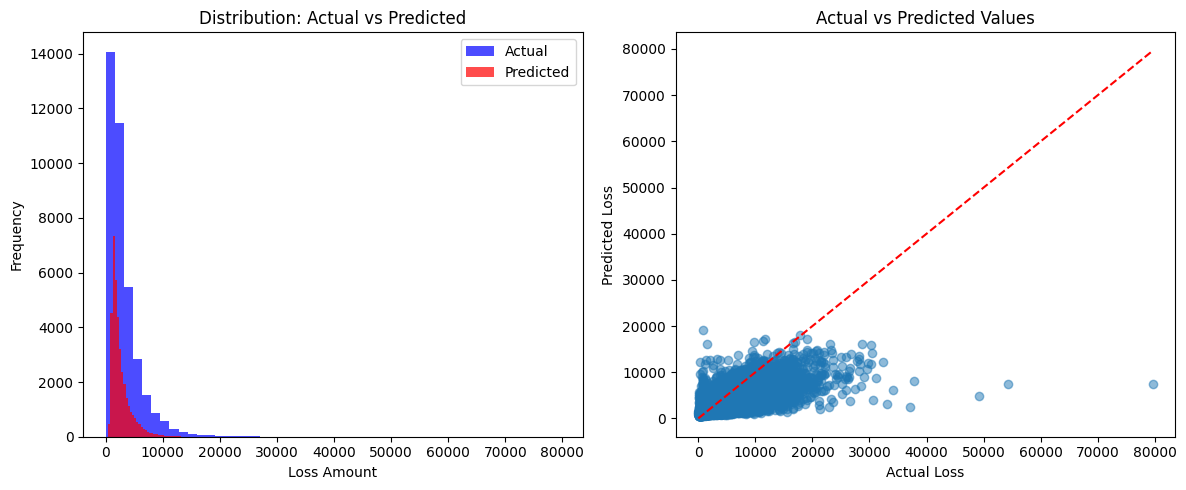


=== Summary Statistics ===
Mean Absolute Error: $1,208.79
Median Absolute Error: $693.51
Root Mean Square Error: $2,087.72
R-squared (log scale): 0.5263
Mean Absolute Percentage Error: 50.72%

=== Training Complete ===


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, median_absolute_error
import matplotlib.pyplot as plt
import time

# Load the data
from google.colab import drive
drive.mount('/content/drive')
filepath = "/content/drive/MyDrive/claims_data (1).csv"
df = pd.read_csv(filepath)

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn types:")
print(df.dtypes.value_counts())
print("\nMissing values:")
print(df.isnull().sum().sum())

# Data Exploration
print("\n=== Data Exploration ===")
print("Target variable distribution:")
print(f"Original loss - Mean: ${df['loss'].mean():.2f}, Std: ${df['loss'].std():.2f}")
print(f"Min: ${df['loss'].min():.2f}, Max: ${df['loss'].max():.2f}")

# Apply log transformation to target variable
df['log_loss'] = np.log1p(df['loss'])
y = df['log_loss']
print(f"Log loss - Mean: {y.mean():.4f}, Std: {y.std():.4f}")

# Define feature columns
categorical_cols = [f'cat{i}' for i in range(1, 116)]
numerical_cols = [f'cont{i}' for i in range(1, 15)]
X = df[numerical_cols + categorical_cols]

print(f"\nNumber of categorical features: {len(categorical_cols)}")
print(f"Number of numerical features: {len(numerical_cols)}")

# Check for high cardinality categorical features
print("\nChecking categorical feature cardinality:")
for col in categorical_cols[:10]:  # Check first 10 to avoid too much output
    unique_count = X[col].nunique()
    print(f"{col}: {unique_count} unique values")

# Enhanced Preprocessing
print("\n=== Preprocessing Data ===")
X_processed = X.copy()
label_encoders = {}

# Handle numerical missing values
X_processed[numerical_cols] = X_processed[numerical_cols].fillna(
    X_processed[numerical_cols].median()
)

# Handle categorical variables with rare categories
for col in categorical_cols:
    # Fill NaN
    X_processed[col] = X_processed[col].fillna('MISSING')

    # Group rare categories (appearing less than 1%)
    value_counts = X_processed[col].value_counts(normalize=True)
    rare_categories = value_counts[value_counts < 0.01].index
    if len(rare_categories) > 0:
        X_processed[col] = X_processed[col].replace(rare_categories, 'RARE')

    # Label encoding
    le = LabelEncoder()
    X_processed[col] = le.fit_transform(X_processed[col].astype(str))
    label_encoders[col] = le

print("Preprocessing completed!")

# Train-test split
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=pd.qcut(y, 5)  # Stratified split
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Evaluation function
def evaluate_model(y_true_log, y_pred_log, model_name):
    y_true_orig = np.expm1(y_true_log)
    y_pred_orig = np.expm1(y_pred_log)

    metrics = {
        'Model': model_name,
        'R² (log scale)': r2_score(y_true_log, y_pred_log),
        'MAE (log scale)': mean_absolute_error(y_true_log, y_pred_log),
        'RMSE (log scale)': np.sqrt(mean_squared_error(y_true_log, y_pred_log)),
        'MAE (original)': mean_absolute_error(y_true_orig, y_pred_orig),
        'Median AE (original)': median_absolute_error(y_true_orig, y_pred_orig),
        'RMSE (original)': np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    }

    return metrics

# Optimized Random Forest Training
print("\n=== Training Optimized Random Forest ===")
start_time = time.time()

rf_optimized = RandomForestRegressor(
    n_estimators=100,           # Balanced for performance and time
    max_depth=20,               # Slightly deeper for complex patterns
    max_features=0.3,           # Optimal for high-dimensional data
    min_samples_split=20,       # More flexible splitting
    min_samples_leaf=10,        # Balance between overfitting and performance
    max_samples=0.8,            # Use bootstrap sampling
    n_jobs=-1,                  # Use all CPU cores
    random_state=42,
    verbose=1
)

# Cross-validation
print("Performing cross-validation...")
cv_scores = cross_val_score(rf_optimized, X_train, y_train_log,
                           cv=3, scoring='neg_mean_absolute_error')
print(f"Cross-validation MAE: {-cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Train the model
print("Training final model...")
rf_optimized.fit(X_train, y_train_log)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

# Make predictions
log_predictions = rf_optimized.predict(X_test)

# Evaluate the model
print("\n=== Model Evaluation ===")
metrics = evaluate_model(y_test_log, log_predictions, "Optimized Random Forest")
for key, value in metrics.items():
    if key == 'Model':
        print(f"\n{key}: {value}")
    else:
        print(f"{key}: {value:.4f}")

# Feature Importance Analysis
print("\n=== Feature Importance Analysis ===")
feature_importance = pd.DataFrame({
    'feature': numerical_cols + categorical_cols,
    'importance': rf_optimized.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 15 Most Important Features:")
print(feature_importance.head(15))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Cumulative feature importance
cumulative_importance = feature_importance['importance'].cumsum()
features_95 = feature_importance[cumulative_importance <= 0.95]
print(f"\nNumber of features explaining 95% of importance: {len(features_95)}")

# Error Analysis
print("\n=== Error Analysis ===")
original_predictions = np.expm1(log_predictions)
y_test_original = np.expm1(y_test_log)
residuals = y_test_log - log_predictions
residuals_original = y_test_original - original_predictions

# Residual plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(log_predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values (log scale)')
plt.ylabel('Residuals')
plt.title('Residual Plot (Log Scale)')

plt.subplot(1, 3, 2)
plt.scatter(original_predictions, residuals_original, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values (Original Scale)')
plt.ylabel('Residuals')
plt.title('Residual Plot (Original Scale)')

plt.subplot(1, 3, 3)
plt.hist(residuals_original, bins=50, alpha=0.7)
plt.xlabel('Residuals (Original Scale)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

plt.tight_layout()
plt.show()

# Prediction distribution comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_test_original, bins=50, alpha=0.7, label='Actual', color='blue')
plt.hist(original_predictions, bins=50, alpha=0.7, label='Predicted', color='red')
plt.xlabel('Loss Amount')
plt.ylabel('Frequency')
plt.title('Distribution: Actual vs Predicted')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test_original, original_predictions, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()], 'red', linestyle='--')
plt.xlabel('Actual Loss')
plt.ylabel('Predicted Loss')
plt.title('Actual vs Predicted Values')

plt.tight_layout()
plt.show()

# Summary Statistics
print("\n=== Summary Statistics ===")
print(f"Mean Absolute Error: ${metrics['MAE (original)']:,.2f}")
print(f"Median Absolute Error: ${metrics['Median AE (original)']:,.2f}")
print(f"Root Mean Square Error: ${metrics['RMSE (original)']:,.2f}")
print(f"R-squared (log scale): {metrics['R² (log scale)']:.4f}")

# Calculate percentage error
percentage_error = np.mean(np.abs(residuals_original / y_test_original)) * 100
print(f"Mean Absolute Percentage Error: {percentage_error:.2f}%")

print("\n=== Training Complete ===")